In [1]:
import pandas as pd
from nltk import word_tokenize
from gensim.models import word2vec
from nltk import FreqDist
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV

from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import numpy as np

import seaborn as sns

from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.layers import Input,Dense,LSTM,Embedding
from tensorflow.keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.utils import to_categorical

import tensorflow as tf

import keras

from wordcloud import WordCloud, STOPWORDS 

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Biel_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Biel_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Biel_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
df = pd.read_csv('winemag-data_first150k.csv',index_col='Unnamed: 0')
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...
150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


In [20]:
#CREATING DF WITH ONLY DESCRIPTION AND POINTS COLUMNS
columns = ['description','points','province']
df = df[columns]
df

df.dropna(axis=0,inplace=True)
df.reset_index()
df

df['description'] = df['description']+' '+df['province']

df.drop(columns = 'province',axis=1,inplace=True)

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [21]:
#CHECKING FOR NULL VALUES
print(df.isna().sum())

#REPLACING POINT WITH CATEGORIES (<85: NOT RECOMMENDED,85-92: VERY GOOD. 91>: CLASSIC)

replace_dict = {}

for i in range(80,101):
    if i <= 86:
        replace_dict[i] = 'NOT RECOMMENDED'
    elif (i > 86 and i < 91):
        replace_dict[i] = 'VERY GOOD'
    else:
        replace_dict[i] = 'OUTSTANDING'
df['points'] = df['points'].replace(replace_dict)

#GETTING POINTS DISTRIBUTION
df['points'].value_counts(normalize = True)
df

description    0
points         0
dtype: int64


C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,description,points
0,This tremendous 100% varietal wine hails from ...,OUTSTANDING
1,"Ripe aromas of fig, blackberry and cassis are ...",OUTSTANDING
2,Mac Watson honors the memory of a wine once ma...,OUTSTANDING
3,"This spent 20 months in 30% new French oak, an...",OUTSTANDING
4,"This is the top wine from La Bégude, named aft...",OUTSTANDING
...,...,...
150925,Many people feel Fiano represents southern Ita...,OUTSTANDING
150926,"Offers an intriguing nose with ginger, lime an...",OUTSTANDING
150927,This classic example comes from a cru vineyard...,OUTSTANDING
150928,"A perfect salmon shade, with scents of peaches...",VERY GOOD


In [23]:
stopwords_list = stopwords.words('english')

# Add punctuation to stopwords_list
stopwords_list.extend(string.punctuation)



# Add the additional Tweet Punctuation below to stopwords_list
additional_punc = ['“','”','...',"''",'’','``']
stopwords_list.extend(additional_punc)

stopwords_list.extend(['wine','drink','fruit','flavors','finish','black','acidity','good','tannin','tannins',
                      'aroma','aromas','palate','ripe','cherry','spice'])

stopwords_list[-1]

'spice'

# VANILLA RANDOM FORREST

In [24]:
rf = RandomForestClassifier(class_weight='balanced')

In [25]:
y = df['points'].copy()
X=df['description'].copy()
X

0         This tremendous 100% varietal wine hails from ...
1         Ripe aromas of fig, blackberry and cassis are ...
2         Mac Watson honors the memory of a wine once ma...
3         This spent 20 months in 30% new French oak, an...
4         This is the top wine from La Bégude, named aft...
                                ...                        
150925    Many people feel Fiano represents southern Ita...
150926    Offers an intriguing nose with ginger, lime an...
150927    This classic example comes from a cru vineyard...
150928    A perfect salmon shade, with scents of peaches...
150929    More Pinot Grigios should taste like this. A r...
Name: description, Length: 150925, dtype: object

In [26]:
#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,
                                                    random_state=69)

In [27]:
# Check y_train and y_test value counts

y_train.value_counts(1)

VERY GOOD          0.446414
NOT RECOMMENDED    0.338877
OUTSTANDING        0.214709
Name: points, dtype: float64

In [28]:
X_train

80603     Lean and rather severe, this is now showing ma...
56956     This rich botrytized wine is certainly sweet. ...
45539     The name suggests the Aussie Shiraz style of t...
1948      Full bodied, this opens with aromas of vanilla...
58779     With plenty of weight, but weight that is conc...
                                ...                        
37144     This is an unusual white made from red Touriga...
142902    After scoring big in 2003, this vintage seems ...
25017     A very mineral wine, with a lean and flinty ch...
140895    Haven't seen this bottling in a couple of year...
122063    For consumers used to Barossa-style Shiraz, th...
Name: description, Length: 120740, dtype: object

In [29]:
tokenizer = nltk.TweetTokenizer(preserve_case=False)
tokenizer


In [30]:
## Make a TfIdf Vectorizer using tweet tokenizer's .tokenize method
vectorizer = TfidfVectorizer(#tokenizer=tokenizer.tokenize,
                           stop_words=stopwords_list)

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

<120740x29158 sparse matrix of type '<class 'numpy.float64'>'
	with 2659924 stored elements in Compressed Sparse Row format>

In [31]:
print (len(vectorizer.vocabulary_))
vectorizer.vocabulary_


29158


{'lean': 14552,
 'rather': 20831,
 'severe': 23059,
 'showing': 23282,
 'maturity': 15922,
 'leathery': 14573,
 'texture': 25995,
 'hint': 12517,
 'juicy': 13823,
 'background': 2294,
 'bordeaux': 3360,
 'rich': 21555,
 'botrytized': 3436,
 'certainly': 4872,
 'sweet': 25367,
 'intense': 13308,
 'dry': 8365,
 'botrytis': 3433,
 'character': 4998,
 'much': 16967,
 'evident': 9326,
 'edge': 8603,
 'bitter': 3025,
 'honey': 12614,
 'crushed': 6946,
 'brown': 3825,
 'sugar': 25015,
 'tight': 26204,
 'taut': 25744,
 'put': 20468,
 'youth': 29008,
 'potentially': 19826,
 'delicious': 7492,
 'needs': 17282,
 'aging': 986,
 'least': 14570,
 'another': 1543,
 'five': 10154,
 'years': 28960,
 'loire': 15050,
 'valley': 27627,
 'name': 17176,
 'suggests': 25029,
 'aussie': 2148,
 'shiraz': 23211,
 'style': 24880,
 'richly': 21563,
 'fruity': 10834,
 'syrah': 25450,
 'offers': 17858,
 'mouthburst': 16914,
 'raspberries': 20809,
 'blackberries': 3038,
 'cherries': 5147,
 'cocoa': 5715,
 'bacon': 23

In [32]:
corpus = df['description'].to_list()
tokens = word_tokenize(','.join(corpus))
stopped_tokens= [w.lower() for w in tokens if w.lower() not in stopwords_list]


(-0.5, 399.5, 199.5, -0.5)

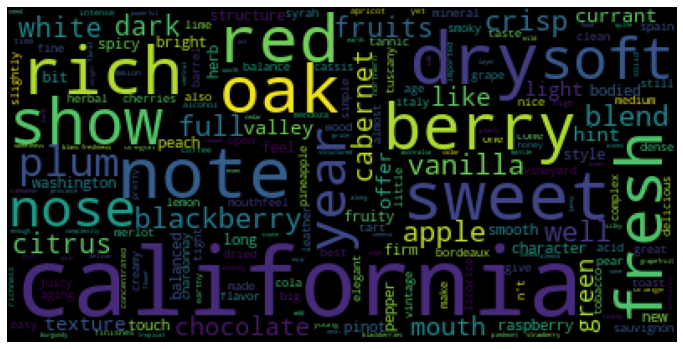

In [33]:
#WORD CLOUD WITH WHOLE CORPUS

wordcloud = WordCloud(stopwords=stopwords_list,collocations=False)
wordcloud.generate(','.join(stopped_tokens))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

In [34]:
df_vg = df[df['points'] == 'VERY GOOD']
df_nr = df[df['points'] == 'NOT RECOMMENDED']
df_ot = df[df['points'] == 'OUTSTANDING']

corpus_vg = df_vg['description'].to_list()
corpus_nr = df_nr['description'].to_list()
corpus_ot = df_ot['description'].to_list()

tokens_vg = word_tokenize(','.join(corpus_vg))
stopped_tokens_vg= [w.lower() for w in tokens_vg if w.lower() not in stopwords_list]

tokens_nr = word_tokenize(','.join(corpus_nr))
stopped_tokens_nr= [w.lower() for w in tokens_nr if w.lower() not in stopwords_list]

tokens_ot = word_tokenize(','.join(corpus_ot))
stopped_tokens_ot= [w.lower() for w in tokens_ot if w.lower() not in stopwords_list]


(-0.5, 399.5, 199.5, -0.5)

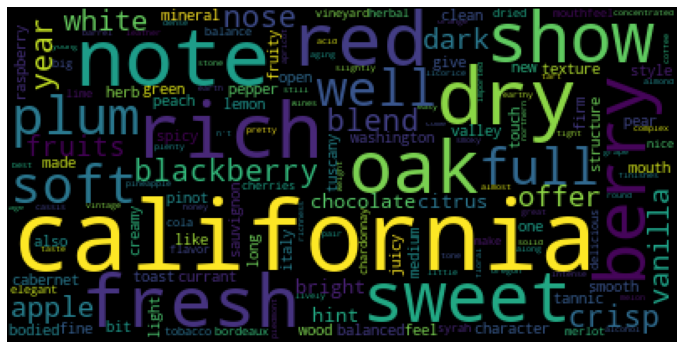

In [35]:
wordcloud.generate(','.join(stopped_tokens_vg))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

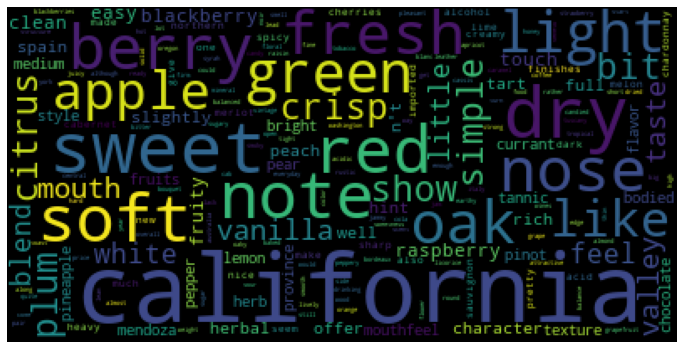

In [36]:
wordcloud.generate(','.join(stopped_tokens_nr))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

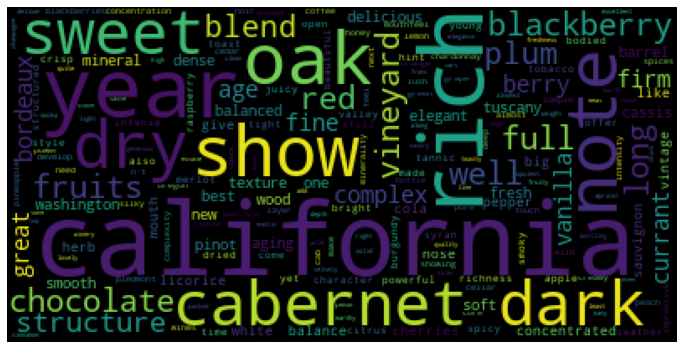

In [37]:
wordcloud.generate(','.join(stopped_tokens_ot))

plt.figure(figsize = (12, 12), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off')

In [38]:
def model_eval(model,X_train,y_train,X_test,y_test,classes=None,
                           normalize='true',cmap='Blues',label=''):

#         """Example function with PEP 484 type annotations.

#         Args:
#             model: The Model Classifier.
#             X_train: X_train being used to fit model (could be scaled or not).
#             y_train: y_train being used to fit model and to get train accuracy.
#             X_test: X_test to get test predictions.
#             y_test: y_test used to get test accuracy
#             classes: Class labels
#             normalize: set to true
#             cmap: Color scheme for Confusion Matrix. Set to Blues
#             label: Confusion Matrix Label

#         Returns:
#             Model Accuracy. Confusion Matrix, ROC Curve, and best params for GridSearch

#     """
    
    
    #FITTING MODEL WITH TRAIN DATA
    model.fit(X_train,y_train)   
      
    #GETTING TRAIN PREDICTIONS
    y_hat_train = model.predict(X_train)
    
    #GETING TEST PREDICTIONS
    y_hat_test = model.predict(X_test)
    
    dashes = '---'*20
    
    if isinstance(model,GridSearchCV):
        grid_header = "GRID SEARCH FOUND THE FOLLOWING OPTIMAL PARAMETERS: "
        print(dashes,grid_header,dashes,sep='\n')
        best_parameters = model.best_params_
        for param_name in sorted(best_parameters.keys()):
            print("%s: %r" % (param_name, best_parameters[param_name]))
    
    #GETTING ACCURACY SCORE FOR TRAIN AND TEST
    
    if len(label)>0:
        accuracy_header = f'{label} ACCURACY'
    else:
        accuracy_header = 'MODEL ACCURACY'
    print(dashes,accuracy_header,dashes,sep='\n')
    training_accuracy = accuracy_score(y_train, y_hat_train)
    testing_accuracy = accuracy_score(y_test, y_hat_test)
    
    print(f'TRAINING ACCURACY: {round(training_accuracy*100,2)}%')
    print(f'TESTING ACCURACY: {round(testing_accuracy*100,2)}%')
          
    #CLASSIFICATION REPORT AND SCORES
    test_header = "CLASSIFICATION REPORT"
    
    #ADDING LABEL IF GIVEN
    if len(label)>0:
        test_header += f" USING {label}"
    
    # PRINT CLASSIFICATION REPORT
    
    print(dashes,test_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test,
                                    target_names=classes))

    print(dashes+"\n\n")
    
    

    # MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,10),ncols=1)
   

    # PLOTTING CONFUSION MATRIX 
    if isinstance(model,GridSearchCV):
        metrics.plot_confusion_matrix(model.best_estimator_, X_test,y_test,
                                      display_labels=classes,
                                      normalize=normalize,
                                     cmap=cmap,ax=axes,xticks_rotation=45)
        axes.set(title='Confusion Matrix')
    else:
        metrics.plot_confusion_matrix(model, X_test,y_test,
                                      display_labels=classes,
                                      normalize=normalize,
                                     cmap=cmap,ax=axes,xticks_rotation=45)
        axes.set(title='Confusion Matrix')
    
    #PLOTTING ROC CURVE
#     roc_plot = metrics.plot_roc_curve(model, X_test, y_test,ax=axes[1])
#     axes[1].legend()
#     axes[1].plot([0,1],[0,1],ls=':')
#     axes[1].grid()
#     axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    fig.tight_layout()
    plt.show()

   

------------------------------------------------------------
MODEL ACCURACY
------------------------------------------------------------
TRAINING ACCURACY: 100.0%
TESTING ACCURACY: 85.45%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
                 precision    recall  f1-score   support

NOT RECOMMENDED       0.90      0.87      0.88     10262
    OUTSTANDING       0.91      0.74      0.82      6313
      VERY GOOD       0.81      0.89      0.85     13610

       accuracy                           0.85     30185
      macro avg       0.87      0.84      0.85     30185
   weighted avg       0.86      0.85      0.85     30185

------------------------------------------------------------




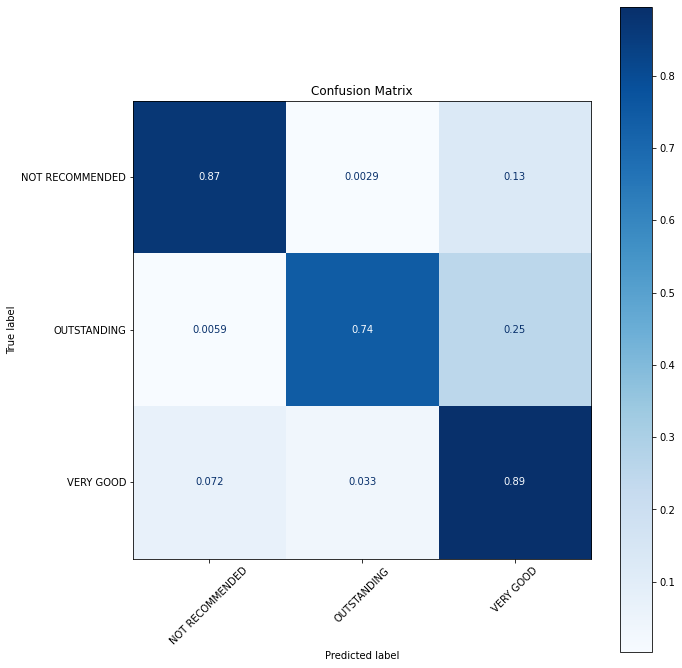

In [39]:
## Evaluate Model using function
model_eval(rf,X_train_tfidf,y_train,X_test_tfidf,y_test)

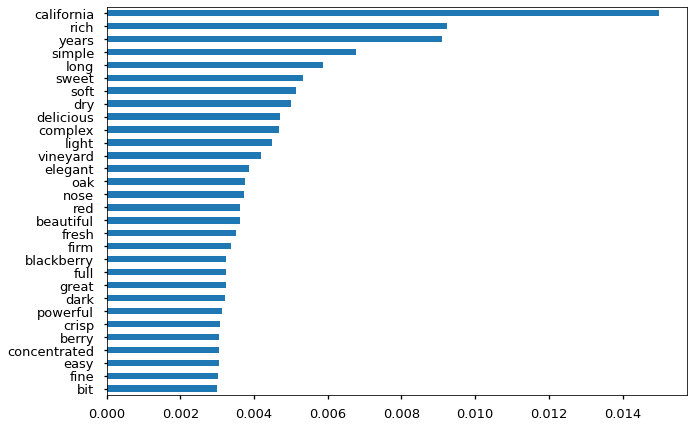

In [40]:
# Plot the top 30 most important features
with plt.style.context('seaborn-talk'):

    ## Get Feature Importance
    importance = pd.Series(rf.feature_importances_,index=vectorizer.get_feature_names())

    ## Sort values 


    ## Take the .tail 30 and plot kind='barh'
    importance.sort_values().tail(30).plot(kind='barh')

In [22]:
count_vect = CountVectorizer()
tf_transform = TfidfTransformer(use_idf=True)
lemmatizer = WordNetLemmatizer()

text_pipe = Pipeline(steps=[                       
    ('count_vectorizer',count_vect),
    ('tf_transformer',tf_transform)])

full_pipe = Pipeline(steps=[
    ('text_pipe',text_pipe),
    ('clf',RandomForestClassifier(class_weight='balanced'))
])
full_pipe

Pipeline(steps=[('text_pipe',
                 Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                 ('tf_transformer', TfidfTransformer())])),
                ('clf', RandomForestClassifier(class_weight='balanced'))])

In [23]:
params = {'text_pipe__tf_transformer__use_idf':[True, False],
         'text_pipe__count_vectorizer__tokenizer':[None,tokenizer.tokenize],
          'text_pipe__count_vectorizer__preprocessor':[None,lemmatizer.lemmatize],
         'text_pipe__count_vectorizer__stop_words':[None,stopwords_list],
         'clf__criterion':['gini', 'entropy']}

## Make and fit grid
grid = GridSearchCV(full_pipe,params,cv=3)

In [24]:
# model_eval(grid,X_train,y_train,X_test,y_test)

# DEEP NLP

In [41]:
def model_eval_2(y_test,y_hat_test,classes=None,
                           normalize='true',cmap='Blues',label='',
                           title='Confusion matrix'):

#         """Example function with PEP 484 type annotations.

#         Args:
#             model: The Model Classifier.
#             X_train: X_train being used to fit model (could be scaled or not).
#             y_train: y_train being used to fit model and to get train accuracy.
#             X_test: X_test to get test predictions.
#             y_test: y_test used to get test accuracy
#             classes: Class labels
#             normalize: set to true
#             cmap: Color scheme for Confusion Matrix. Set to Blues
#             label: Confusion Matrix Label

#         Returns:
#             Model Accuracy. Confusion Matrix, ROC Curve, and best params for GridSearch

#     """
    
    dashes = '---'*20

    #GETTING ACCURACY SCORE FOR TRAIN AND TEST
    
    if len(label)>0:
        accuracy_header = f'{label} ACCURACY'
    else:
        accuracy_header = 'MODEL ACCURACY'
    print(dashes,accuracy_header,dashes,sep='\n')
#     training_accuracy = accuracy_score(y_train, y_hat_train)
    testing_accuracy = accuracy_score(y_test, y_hat_test)
    
#     print(f'TRAINING ACCURACY: {round(training_accuracy*100,2)}%')
    print(f'TESTING ACCURACY: {round(testing_accuracy*100,2)}%')
          
    #CLASSIFICATION REPORT AND SCORES
    test_header = "CLASSIFICATION REPORT"
    
    #ADDING LABEL IF GIVEN
    if len(label)>0:
        test_header += f" USING {label}"
    
    # PRINT CLASSIFICATION REPORT
    
    print(dashes,test_header,dashes,sep='\n')

    print(metrics.classification_report(y_test,y_hat_test))#,
#                                     target_names=classes))

    print(dashes+"\n\n")
        
    # MAKE FIGURE
    fig, axes = plt.subplots(figsize=(15,5),ncols=3)      
   

    # PLOTTING CONFUSION MATRIX 

    cm = confusion_matrix(y_true=y_test, y_pred=y_hat_test,normalize=normalize)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(ax=axes[2])
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    history_df = pd.DataFrame(history.history)
#     plt.subplot(history_df[[col for col in history_df.columns if 'loss' in col]])

    loss_df = history_df[[col for col in history_df.columns if 'loss' in col]]
    loss_df = loss_df.reset_index()
    
    acc_df = history_df[[col for col in history_df.columns if 'acc' in col]]
    acc_df = acc_df.reset_index()
    
    sns.lineplot(x='index',y='val_loss',data=loss_df,marker='o',ax=axes[0])
    sns.lineplot(x='index',y='loss',data=loss_df,marker='o',ax=axes[0])
    
    sns.lineplot(x='index',y='val_accuracy',data=acc_df,marker='o',ax=axes[1])
    sns.lineplot(x='index',y='accuracy',data=acc_df,marker='o',ax=axes[1])
    
    fig.tight_layout()
    plt.show()

   

In [42]:
#TRAINING WORD2VEC FROM FULL DF AND APPLYING SIMPLE PREPROCESSING
lower_df=df['description'].map(lambda x: simple_preprocess(x.lower(),deacc=True,
                                                         max_len=200))

print(df['description'][0])
print('/n')
print(lower_df[0])

This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030. California
/n
['this', 'tremendous', 'varietal', 'wine', 'hails', 'from', 'oakville', 'and', 'was', 'aged', 'over', 'three', 'years', 'in', 'oak', 'juicy', 'red', 'cherry', 'fruit', 'and', 'compelling', 'hint', 'of', 'caramel', 'greet', 'the', 'palate', 'framed', 'by', 'elegant', 'fine', 'tannins', 'and', 'subtle', 'minty', 'tone', 'in', 'the', 'background', 'balanced', 'and', 'rewarding', 'from', 'start', 'to', 'finish', 'it', 'has', 'years', 'ahead', 'of', 'it', 'to', 'develop', 'further', 'nuance', 'enjoy', 'california']


In [27]:
wv_model = Word2Vec(lower_df,size=100,window=6,min_count=1)

In [28]:
wv_model.train(lower_df,total_examples=wv_model.corpus_count,epochs=100)

W0120 15:03:51.484483  8980 base_any2vec.py:1168] Effective 'alpha' higher than previous training cycles


KeyboardInterrupt: 

In [ ]:
#GET KEYED VECTOR
wv=wv_model.wv
wv

In [ ]:
wv['flavor']

In [ ]:
len(wv.vocab)

In [ ]:
wv.most_similar('fruity')

In [43]:
# y=label_binarize(df['is_there_an_emotion_directed_at_a_brand_or_product'].copy(),
#                  classes = ['Negative emotion','Positive emotion','No emotion toward brand or product'])
y = df['points'].replace({'NOT RECOMMENDED':0, 'VERY GOOD':1,'OUTSTANDING':2})
X=df['description'].copy()

In [44]:
#TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,
                                                    random_state=69)

In [45]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',np.unique(y_train),y_train)

weights_dict = dict(zip(np.unique(y_train),weights))
weights_dict

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=80603     0
56956     1
45539     0
1948      1
58779     2
         ..
37144     0
142902    0
25017     1
140895    1
122063    2
Name: points, Length: 120740, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.9836412813243393, 1: 0.746691403834261, 2: 1.552486756159029}

In [46]:
#ONE HOT ENCODE
y_train_seq=label_binarize(y_train,
                 classes = [0,1,2])

y_test_seq=label_binarize(y_test,
                 classes = [0,1,2])
y_train_seq.shape

(120740, 3)

In [47]:
#TOKENIZE TEXT
MAX_WORDS=20000
tokenizer = text.Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

#FIND LONGEST SEQUENCE
max(list(map(lambda x:len(x),[*train_sequences,*test_sequences])))

MAX_SEQUENCE_LENGTH=40

In [48]:
X_train_seq = sequence.pad_sequences(train_sequences,maxlen=MAX_SEQUENCE_LENGTH)

X_test_seq = sequence.pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

X_train_seq

array([[   0,    0,    0, ...,    2,  759,  107],
       [1198,   92,    6, ...,   63,  445,   74],
       [   2, 3810,  577, ...,  567, 1248,   15],
       ...,
       [   0,    0,    3, ...,  192,  513,  441],
       [  11,  343,   12, ...,   33,  753,   74],
       [  28, 2731,    1, ...,  151,   43, 1073]])

In [49]:
len(tokenizer.index_word)

35021

In [50]:
#GOT FROM JAMES
def get_earlystop(monitor='val_loss',patience=4, restore_best_weights=True):
    """"""""
    args = locals()
    return EarlyStopping(**args)

In [51]:
y_test_seq

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [61]:
def make_model(EMBEDDING_SIZE=128):
    model=Sequential()
    model.add(Embedding(MAX_WORDS,EMBEDDING_SIZE))
    model.add(LSTM(32,return_sequences=False,recurrent_dropout=0.2))
#     model.add(LSTM(25,return_sequences=False))

#     model.add(LSTM(50,return_sequences=False,recurrent_dropout=0.3))
    model.add(Dense(32,activation=tf.keras.layers.LeakyReLU()))#,kernel_regularizer=regularizers.l2(0.01)))
#     model.add(Dropout(0.3))
#     model.add(Dense(32,activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    
#     opt = keras.optimizers.Adam(learning_rate=1)
    model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    display(model.summary())
    return model
model = make_model()
history = model.fit(X_train_seq, y_train_seq, epochs=50,batch_size=64, 
                    validation_split = 0.2, callbacks=get_earlystop(),
                   class_weight=weights_dict,workers=3)
y_hat_test = model.predict(X_test_seq).argmax(axis=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 2,581,763
Trainable params: 2,581,763
Non-trainable params: 0
_________________________________________________________________


None

Epoch 1/50
1510/1510 [==============================] - 71s 47ms/step - loss: 0.6155 - accuracy: 0.6917 - val_loss: 0.5866 - val_accuracy: 0.7240
Epoch 2/50
1510/1510 [==============================] - 74s 49ms/step - loss: 0.4837 - accuracy: 0.7735 - val_loss: 0.5833 - val_accuracy: 0.7339
Epoch 3/50
1510/1510 [==============================] - 77s 51ms/step - loss: 0.4085 - accuracy: 0.8120 - val_loss: 0.5491 - val_accuracy: 0.7680
Epoch 4/50
1510/1510 [==============================] - 81s 54ms/step - loss: 0.3478 - accuracy: 0.8422 - val_loss: 0.5752 - val_accuracy: 0.7674
Epoch 5/50
1510/1510 [==============================] - 86s 57ms/step - loss: 0.2929 - accuracy: 0.8669 - val_loss: 0.5761 - val_accuracy: 0.7843
Epoch 6/50
1510/1510 [==============================] - 93s 61ms/step - loss: 0.2483 - accuracy: 0.8875 - val_loss: 0.6502 - val_accuracy: 0.7869
Epoch 7/50
1510/1510 [==============================] - 94s 62ms/step - loss: 0.2092 - accuracy: 0.9049 - val_loss: 0.6887 -

In [ ]:
model_eval_2(y_test_seq.argmax(axis=1),y_hat_test,classes=[0,1,2])

In [ ]:
def make_model_w2v(wv):
    model=Sequential()
    
    model.add(wv.get_keras_embedding())
    model.add(LSTM(32,return_sequences=False,recurrent_dropout=0.2))
#     model.add(LSTM(25,return_sequences=False))

#     model.add(LSTM(50,return_sequences=False,recurrent_dropout=0.3))
    model.add(Dense(32,activation=tf.keras.layers.LeakyReLU()))#,kernel_regularizer=regularizers.l2(0.01)))
#     model.add(Dropout(0.3))
#     model.add(Dense(32,activation=tf.keras.layers.LeakyReLU(),kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',optimizer='Nadam',metrics=['accuracy'])
    display(model.summary())
    return model
model = make_model_w2v(wv)
history = model.fit(X_train_seq, y_train_seq, epochs=50,batch_size=64,
                    validation_split = 0.2,
                    callbacks=get_earlystop(),
                    class_weight=weights_dict)

In [ ]:
y_hat_test = model.predict(X_test_seq).argmax(axis=1)
model_eval_2(y_test,y_hat_test,classes=[0,1,2])